# 평가 조건
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    - 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

# 1. 모듈 임포트

In [1]:
import nltk
nltk.download('stopwords')

from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. 데이터 불러오기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
44544,HC grants Karti interim relief from arrest in ...,The Delhi High Court has granted Karti Chidamb...
88028,Global passport system down; delay at internat...,The global passport security system was down o...
12122,400 Bihar police officers dismissed for violat...,More than 400 police officers in Bihar have be...
88138,98% of computers hit by WannaCry were running ...,According to a report by cybersecurity firm Ka...
89034,Hydrogen bonds detected for the first time,"In a first, Switzerland-based scientists have ..."
76770,We feel US ready for dialogue despite tensions...,Russia believes US is ready to continue dialog...
58012,Deepika has my support but wary of Azmi's peti...,"Kangana Ranaut, while responding to reports of..."
33663,SoftBank wants Flipkart to wait for Amazon off...,SoftBank is convincing Flipkart's key sharehol...
1273,3-day mourning in Karnataka after death of Shi...,The Karnataka government has declared a three-...
93235,11-yr-old becomes youngest in Telangana to cle...,"A boy from Hyderabad, Agastya Jaiswal, became ..."


In [4]:
print(len(data))

98401


- 해당 데이터는 총 98,401개로 headline(요약문)과 text(원문)로 이루어져 있음
- 추상적 요약을 하는 경우에는 text를 본문, headlines를 요약문으로 이용하여 모델을 학습할 수 있고, 추출적 요약을 하는 경우에는 text열만을 사용

# 3. 데이터 전처리 하기
## 중복 샘플과 NULL 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 데이터의 중복은 조금 있지만, 널값은 없는것으로 확인됨

In [7]:
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 텍스트 정규화와 불용어 제거
- 텍스트 정규화: 자연어 처리 분야에서 텍스트를 사전에 처리하는 과정을 말하며, 이 과정에서는 텍스트에서 노이즈나 불필요한 정보를 제거하고, 표준화된 형태로 변환하는 작업을 수행
1. 토큰화(Tokenization): 문장을 단어나 구절 등으로 분할하는 작업
2. 대소문자 통일(Case folding): 대소문자를 통일하는 작업
3. 불용어 제거(Stopword removal): 분석에 불필요한 단어를 제거하는 작업
4. 표제어 추출(Lemmatization): 단어의 원형을 추출하는 작업
5. 어간 추출(Stemming): 단어의 어간을 추출하는 작업
6. 특수 문자 제거(Special character removal): 특수 문자를 제거하는 작업

등이 있음

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- summary는 상대적으로 길이가 짧기 때문에 불용어를 제거하게 되면 부자연스러운 문장이 되어 불용어 전처리를 하지 않음

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z0-9\.,]", " ", sentence) # 문자, 숫자, 온점, 반점 이외의 모든 문자를 공백으로 대체
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords: 
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []

for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", data['text'][:1])
print("text 전처리 후 결과: ", clean_text[:1])

100%|██████████| 98360/98360 [08:47<00:00, 186.48it/s]

text 전처리 후 결과:  0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
Name: text, dtype: object
text 전처리 후 결과:  ['saurav kant, alumnus upgrad iiit pg program machine learning artificial intelligence, sr systems engineer infosys almost years work experience. program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike. upgrad online power learning powered lakh careers.']


In [12]:
clean_headlines = []

for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", data['headlines'][:1])
print("headlines 전처리 후 결과: ", clean_headlines[:1])

100%|██████████| 98360/98360 [00:16<00:00, 6015.94it/s]

headlines 전처리 후 결과:  0    upGrad learner switches to career in ML & Al w...
Name: headlines, dtype: object
headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with 90 salary hike']


- 전처리가 잘 된 것으로 확인이 됨

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

- 전처리가 된 데이터로 text와 headline을 바꾸어주고, 대체과정 중 생긴 공백을 nan값으로 대체해주었음

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

text 최소 길이: 4
text 평균 길이: 265.00320252135015
text 최대 길이: 377
---------------------------------------------------------------------------
headlines 최소 길이: 9
headlines 평균 길이: 55.80030500203335
headlines 최대 길이: 78


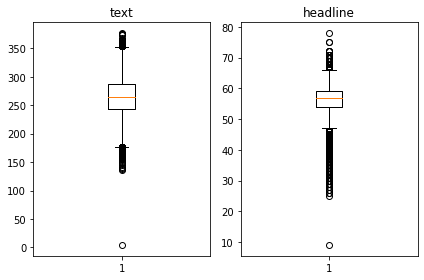

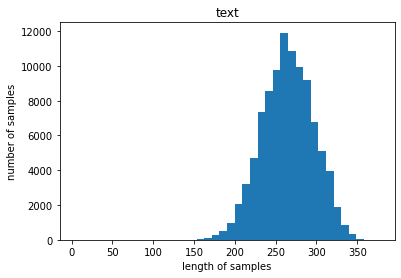

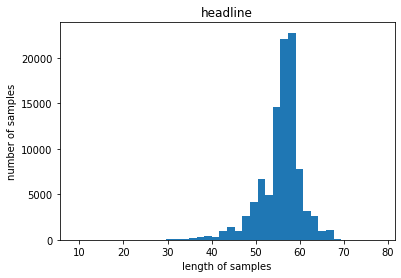

In [15]:
#길이 분포 출력

text_len = [len(s) for s in data['text']]
headlines_len = [len(s) for s in data['headlines']]

print('text 최소 길이: {}'.format(np.min(text_len)))
print('text 평균 길이: {}'.format(np.mean(text_len)))
print('text 최대 길이: {}'.format(np.max(text_len)))
print('-----'*15)
print('headlines 최소 길이: {}'.format(np.min(headlines_len)))
print('headlines 평균 길이: {}'.format(np.mean(headlines_len)))
print('headlines 최대 길이: {}'.format(np.max(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headline')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 원문의 길이와 요약문의 길이를 봤는데, 이것이 전처리가 잘된것인지 모르겠음..
- 원문이 요약문보다 짧은 경우가 있을까?
- 일단 이상치라고 생각하지 않고 분석을 진행함
- 그래프를 보았을때, text는 325 / headline은 65 이하의 길이를 가지고 있는것으로 판단됨

In [16]:
text_max_len = 320
head_max_len = 65

In [17]:
def len_control(max_len, data_list):
    c = 0
    for s in data_list:
        if len(s) < max_len:
            c += 1
    print('전체 데이터 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (c/len(data_list))))

In [18]:
len_control(text_max_len, data['text'])
len_control(head_max_len, data['headlines'])

전체 데이터 중 길이가 320 이하인 샘플의 비율: 0.961864579097194
전체 데이터 중 길이가 65 이하인 샘플의 비율: 0.977643350955673


- text는 max_len 기준 이하인 데이터가 약 96%, headline은 max_len 기준 이하인 데이터가 약 97%를 포함하는것으로 나타남

In [19]:
data = data[data['text'].apply(lambda x: len(x) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x) <= head_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 93730


- max_len 길이 이하의 데이터 제외시켰을때, 전체 샘플 수에서 약 5,000개정도 제외되었음

## 시작 토큰과 종료 토큰 추가하기
- seq2seq 훈련을 위해서 디코더의 입력과 타겟에 시작 토큰과 종료 토큰을 추가
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가

In [20]:
# headline data에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,"saurav kant, alumnus upgrad iiit pg program ma...",sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,"kunal shah credit card bill payment platform, ...",sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india 12 matc...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india 12 matc...
3,aegon life iterm insurance plan helps customer...,"aegon life iterm insurance plan, customers enj...",sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
encoder_input

array(['saurav kant, alumnus upgrad iiit pg program machine learning artificial intelligence, sr systems engineer infosys almost years work experience. program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike. upgrad online power learning powered lakh careers.',
       'kunal shah credit card bill payment platform, cred, gave users chance win free food swiggy one year. pranav kaushik, delhi techie, bagged reward spending 2000 cred coins. users get one cred coin per rupee bill paid, used avail rewards brands like ixigo, bookmyshow, ubereats, cult.fit more.',
       'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series. india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018. match witnessed india getting 92, seventh lowest total odi cricket history.',
       ...,
       'according reports, new version 1999 science fiction film matrix development. m

## 데이터 shuffling 및 split

In [23]:
indices = np.arange(encoder_input.shape[0])
print(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

93730
[66076 50776 53881 ... 82720 37730 17666]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
encoder_input

array(['since january 2013, rohit sharma scored 1,104 runs 13 matches australia, averaging 110.4 strike rate 102.88. period, average first innings score odis featuring india australia 321 runs. notably, australia last bilateral odi series india 2013 14 season resulted series win india.',
       'rajya sabha adjourned wednesday ruckus debate bill criminalising instant triple talaq. bill earlier passed lok sabha opposition parties, including congress, voting favour. however, opposition demanded upper house bill sent select committee enacted.',
       'mumbai police registered fir unknown person allegedly molesting 17 year old actress zaira wasim board air vistara flight. case registered section 354 ipc protection children sexual offences act. ministry civil aviation sought details air vistara national commission women demanded probe.',
       ...,
       'south african pacer kagiso rabada become youngest bowler since 1998 hold number one odi rank. rabada, aged 22 years five days, rose to

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18746


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 74984
훈련 레이블의 개수 : 74984
테스트 데이터의 개수 : 18746
테스트 레이블의 개수 : 18746


## 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [28]:
tokenizer = Tokenizer() #토크나이저 정의
tokenizer.fit_on_texts(encoder_input_train) #입력된 데이터로부터 단어 집합 생성

In [29]:
tokenizer.word_index

{'said': 1,
 'india': 2,
 'added': 3,
 'year': 4,
 'us': 5,
 'also': 6,
 'first': 7,
 'police': 8,
 'government': 9,
 'people': 10,
 'two': 11,
 'indian': 12,
 'old': 13,
 'film': 14,
 'minister': 15,
 'president': 16,
 'one': 17,
 'world': 18,
 'court': 19,
 'crore': 20,
 'state': 21,
 'years': 22,
 'would': 23,
 'reportedly': 24,
 '000': 25,
 'new': 26,
 'time': 27,
 'delhi': 28,
 'former': 29,
 'last': 30,
 'reports': 31,
 'three': 32,
 'company': 33,
 'man': 34,
 'congress': 35,
 'earlier': 36,
 'bjp': 37,
 'like': 38,
 'country': 39,
 '1': 40,
 'day': 41,
 'trump': 42,
 'team': 43,
 'claimed': 44,
 'based': 45,
 'accused': 46,
 'modi': 47,
 'chief': 48,
 'pakistan': 49,
 'actor': 50,
 'singh': 51,
 'pm': 52,
 '10': 53,
 'women': 54,
 'allegedly': 55,
 'according': 56,
 'made': 57,
 'friday': 58,
 'pradesh': 59,
 'million': 60,
 'party': 61,
 'monday': 62,
 'tuesday': 63,
 'comes': 64,
 'wednesday': 65,
 'woman': 66,
 'lakh': 67,
 'called': 68,
 'video': 69,
 'asked': 70,
 'around'

- tokenizer가 잘 정의된것을 알 수 있음

In [30]:
threshold = 7
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 70001
등장 빈도가 6번 이하인 희귀 단어의 수: 47530
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22471
단어 집합에서 희귀 단어의 비율: 67.89903001385694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5288365592062334


- 전체 vocab의 크기는 70001개임
- 등장빈도가 6번 이하인 단어는 47530개를 차지함
- 전체 vocab에서 희귀 단어의 등장 빈도는 3.52%밖에 되지 않음
- 따라서 6회 이하만 등장한 단어는 제거하고, vocab의 크기를 약 22000개로 제한하고 재생성해줌

In [31]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [32]:
# 인코터 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[105, 444, 784, 942, 262, 424, 40, 5297, 276, 362, 641, 199, 4106, 255, 946, 935, 4362, 3363, 747, 1206, 7, 631, 753, 1703, 1776, 2, 199, 13854, 276, 109, 199, 30, 2755, 325, 156, 2, 784, 346, 634, 3581, 156, 231, 2], [1440, 433, 9006, 65, 9354, 2942, 490, 14918, 4172, 1716, 2088, 490, 36, 452, 653, 433, 671, 937, 94, 35, 2421, 2265, 104, 671, 770, 3665, 145, 490, 371, 4757, 596, 13000], [82, 8, 422, 1166, 2943, 290, 55, 5088, 317, 4, 13, 80, 8563, 5428, 178, 134, 7572, 273, 78, 422, 1618, 16168, 7262, 1419, 210, 369, 4107, 496, 244, 1160, 1513, 816, 1052, 134, 7572, 88, 442, 54, 770, 696]]


- 디코더 데이터에도 동일한 작업을 수행해줌

In [33]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [34]:
tar_tokenizer.word_index

{'sostoken': 1,
 'to': 2,
 'in': 3,
 'for': 4,
 'of': 5,
 'on': 6,
 'with': 7,
 'india': 8,
 'not': 9,
 'after': 10,
 'at': 11,
 'us': 12,
 'over': 13,
 'from': 14,
 'as': 15,
 'by': 16,
 'the': 17,
 'is': 18,
 'man': 19,
 'be': 20,
 'pm': 21,
 'will': 22,
 'govt': 23,
 'up': 24,
 'old': 25,
 'delhi': 26,
 'trump': 27,
 'world': 28,
 'was': 29,
 'indian': 30,
 'bjp': 31,
 'crore': 32,
 'cm': 33,
 'report': 34,
 'woman': 35,
 'modi': 36,
 'year': 37,
 'new': 38,
 'who': 39,
 'against': 40,
 '1st': 41,
 'his': 42,
 'no': 43,
 'first': 44,
 'have': 45,
 'and': 46,
 'it': 47,
 'my': 48,
 '000': 49,
 'ex': 50,
 'day': 51,
 'out': 52,
 'time': 53,
 'mumbai': 54,
 'film': 55,
 'pak': 56,
 '10': 57,
 'china': 58,
 'do': 59,
 'people': 60,
 'years': 61,
 'police': 62,
 'reports': 63,
 'lakh': 64,
 'women': 65,
 'sc': 66,
 'me': 67,
 'yr': 68,
 'get': 69,
 'case': 70,
 'killed': 71,
 'video': 72,
 'ceo': 73,
 'has': 74,
 'gets': 75,
 'are': 76,
 'rahul': 77,
 'its': 78,
 'if': 79,
 'minister': 8

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31076
등장 빈도가 5번 이하인 희귀 단어의 수: 20576
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10500
단어 집합에서 희귀 단어의 비율: 66.211867679238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.956802315938664


- 디코더 단어장의 크기는 10000개로 제한하여 다시 재생성

In [36]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 524, 539, 3576, 345, 594, 311, 4, 209, 62], [1, 1817, 766, 7698, 11, 7699, 14, 727, 886, 349], [1, 55, 63, 518, 683, 4, 6493, 4871, 2455, 71], [1, 24, 2295, 1224, 702, 3, 2954, 1149, 4, 27, 4401], [1, 4551, 128, 68, 12, 7700, 6494, 2120, 3, 325]]
target
decoder  [[524, 539, 3576, 345, 594, 311, 4, 209, 62, 2], [1817, 766, 7698, 11, 7699, 14, 727, 886, 349, 2], [55, 63, 518, 683, 4, 6493, 4871, 2455, 71, 2], [24, 2295, 1224, 702, 3, 2954, 1149, 4, 27, 4401, 2], [4551, 128, 68, 12, 7700, 6494, 2120, 3, 325, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74984
훈련 레이블의 개수 : 74984
테스트 데이터의 개수 : 18746
테스트 레이블의 개수 : 18746


- start토큰만 남게되는 경우가 있기에 확인하고 제거하는 작업을 해줌

## 패딩하기

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

In [39]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)

(74984, 320)
(74984, 65)


- 앞서 지정해놓은 max_len를 이용하여 데이터를 패딩시켜주었음

# 4. 모델 설계하기

In [40]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim, mask_zero=True)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.3)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.3)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout = 0.3)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 320, 128)     2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 320, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 임베딩 차원은 128, hidden state의 크기는 256으로 정의함
- 또한 임베딩층에 mask_zero 파라미터를 추가하여 제로 패딩을 무시하도록 하였음
    - 모델의 학습 속도를 높일 수 있으며, 메모리 사용량을 줄일 수 있음. 또한, 마스킹을 적용하여 모델이 실제 입력 데이터에만 집중하도록 도와줌
- 그리고 각 lstm layer마다 과적합 방지를 위한 dropout을 설정해주었음

# 5. 어텐션 메커니즘
- 어텐션(Attention) 메커니즘은 딥러닝 모델에서 시퀀스(sequence) 데이터를 처리할 때 많이 사용되는 기법 중 하나
- 어텐션 메커니즘은 모델이 입력 시퀀스의 모든 요소를 동일한 가중치로 처리하지 않고, 주목해야 할 요소에 더 높은 가중치를 부여하여 처리
- 즉, 입력 시퀀스의 각 요소마다 중요도를 동적으로 계산하여 모델이 그 중요도를 기반으로 필요한 정보에 집중할 수 있도록 함

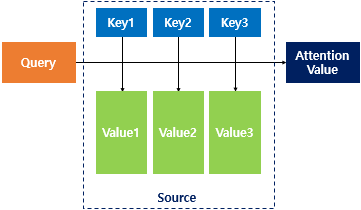

- Attention(Q, K, V) = Attention Value
    - Q = Query : t 시점의 디코더 셀에서의 은닉 상태
    - K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
    - V = Values : 모든 시점의 인코더 셀의 은닉 상태들
- 어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구함. 
- 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영하고, 유사도가 반영된 '값(Value)'을 모두 더해서 리턴

## 닷-프로덕트 어텐션(Dot-Product Attention)

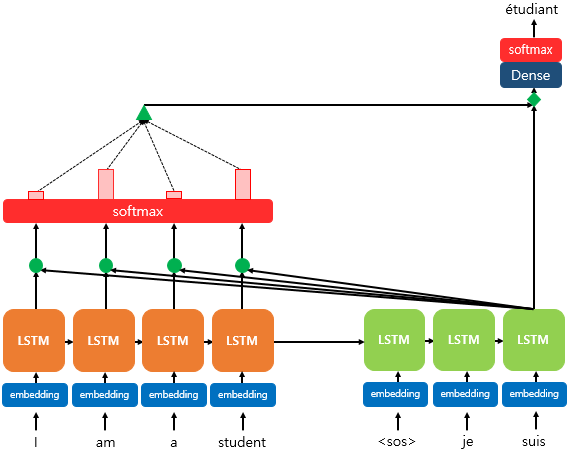

- 디코더의 세번째 LSTM 셀은 출력 단어를 예측하기 위해서 인코더의 모든 입력 단어들의 정보를 다시 한번 참고
- 소프트맥스 함수를 통해 나온 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지의 정도를 수치화한 값
- 빨간 직사각형의 크기로 소프트맥스 함수의 결과값의 크기를 표현
- 직사각형의 크기가 클 수록 도움이 되는 정도의 크기가 큼
- 각 입력 단어가 디코더의 예측에 도움이 되는 정도가 수치화하여 측정되면 이를 하나의 정보로 담아서 디코더로 전송
- 위의 그림에서는 초록색 삼각형이 이에 해당
- 결과적으로, 디코더는 출력 단어를 더 정확하게 예측할 확률이 높아짐

1. 어텐션 스코어(Attention Score)를 구한다.
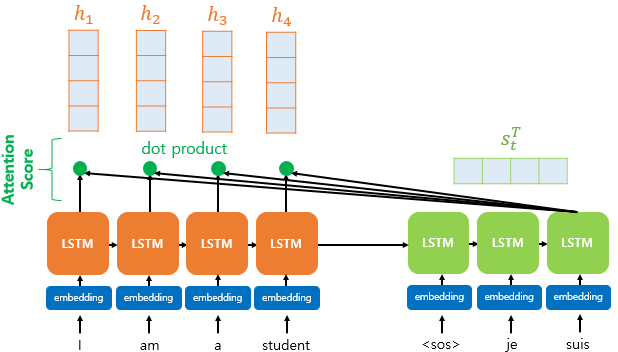
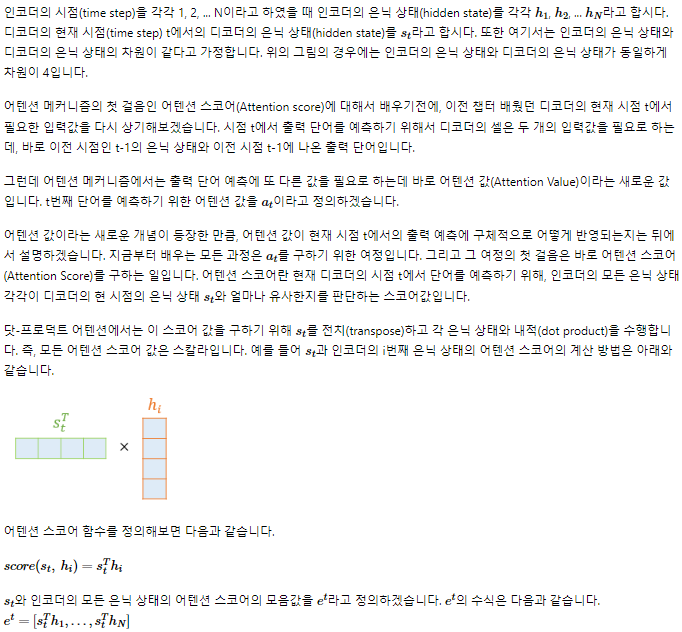


2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.
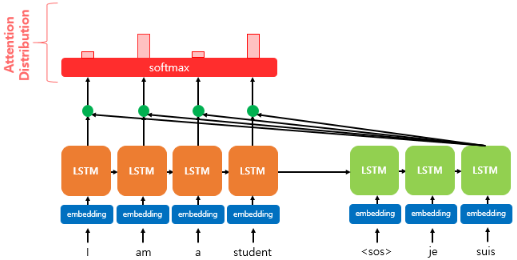
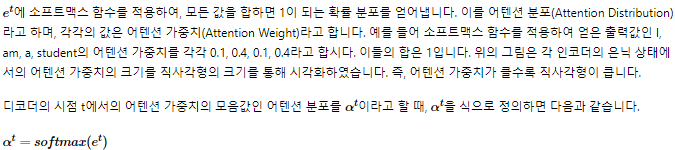


3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.
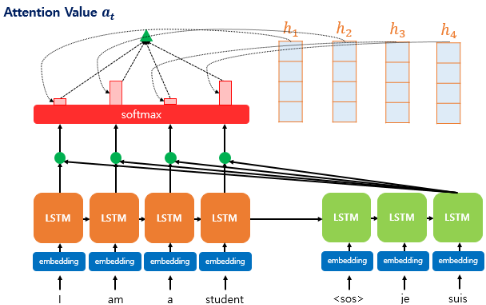
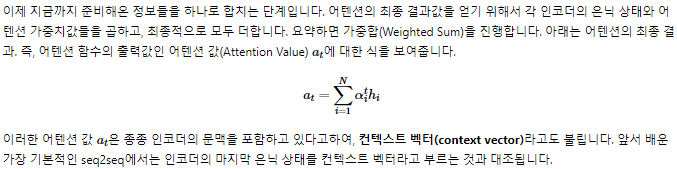


4. 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)
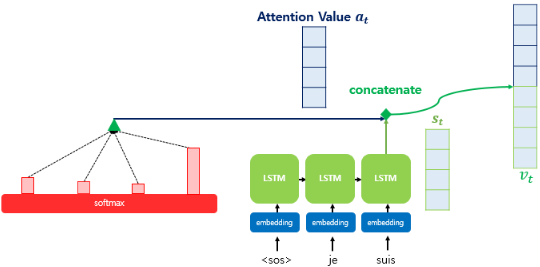
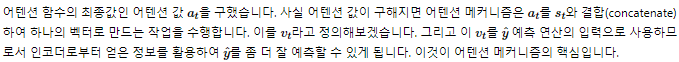


5. 출력층 연산의 입력이 되는 s^t를 계산합니다.
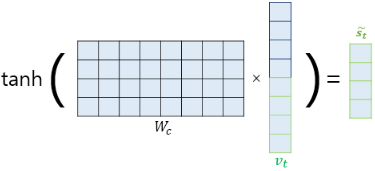
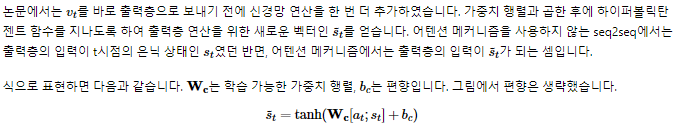


6. s^t를 출력층의 입력으로 사용합니다.
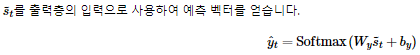

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 320, 128)     2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 320, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

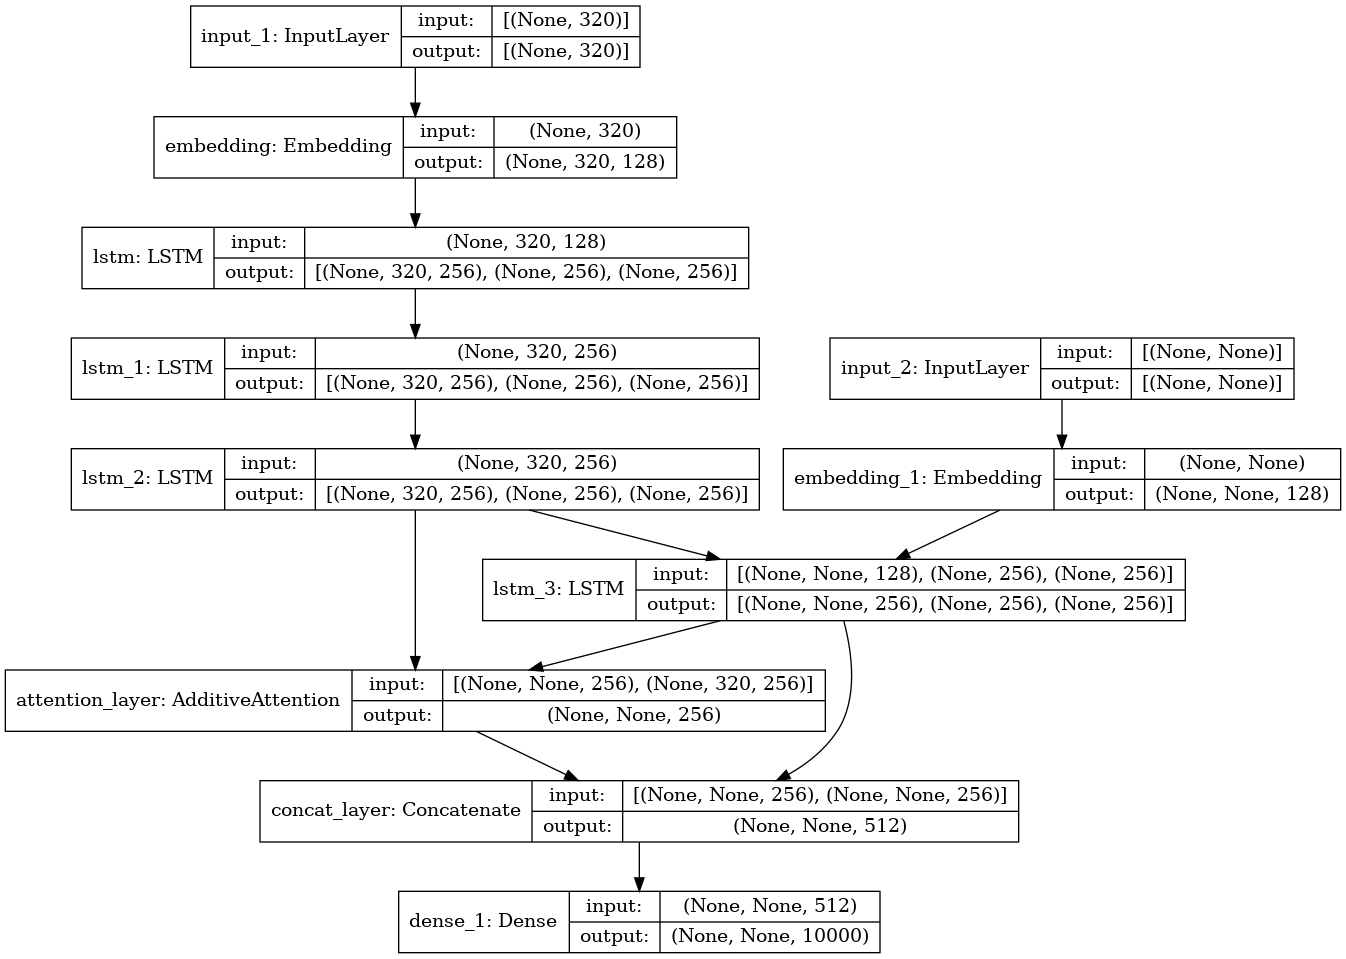

In [46]:
from tensorflow import keras
keras.utils.plot_model(model,"new_summary_model.png", show_shapes=True) 

# 6. 모델 훈련하기

In [48]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=128, callbacks=[es], epochs=50)

Epoch 1/50
586/586 [==============================] - 239s 387ms/step - loss: 1.0461 - val_loss: 0.9692
Epoch 2/50
586/586 [==============================] - 222s 380ms/step - loss: 0.9375 - val_loss: 0.8938
Epoch 3/50
586/586 [==============================] - 222s 380ms/step - loss: 0.8714 - val_loss: 0.8444
Epoch 4/50
586/586 [==============================] - 222s 380ms/step - loss: 0.8234 - val_loss: 0.8114
Epoch 5/50
586/586 [==============================] - 222s 380ms/step - loss: 0.7864 - val_loss: 0.7882
Epoch 6/50
586/586 [==============================] - 223s 380ms/step - loss: 0.7562 - val_loss: 0.7708
Epoch 7/50
586/586 [==============================] - 223s 380ms/step - loss: 0.7316 - val_loss: 0.7568
Epoch 8/50
586/586 [==============================] - 222s 380ms/step - loss: 0.7097 - val_loss: 0.7469
Epoch 9/50
586/586 [==============================] - 222s 380ms/step - loss: 0.6910 - val_loss: 0.7410
Epoch 10/50
586/586 [==============================] - 222s 380m

- restore_best_weights는 검증 데이터의 성능이 가장 좋았을 때 저장된 모델 가중치를 복원하는 인수로 True로 설정하면, 조기 종료 시점에서 가장 좋았던 모델 가중치를 사용하여 학습을 완료할 수 있음

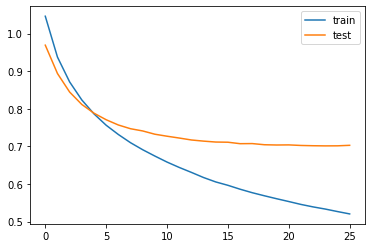

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 7. 테스트 하기

In [50]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [51]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [52]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (head_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [54]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [55]:
for i in [7,77,777,7777]:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre thursday told supreme court rohingya muslims cannot allowed stay india refugees threat national security affidavit centre said rohingya muslims could used domestic foreign terror groups create trouble country national interest warrants deportation added 
실제 요약 : rohingya muslims threat to national security govt to sc 
예측 요약 :  no one can be allowed to stop the country of india govt


원문 : partner professional services firm young us alleged firm ignored complaints another partner groped assaulted 2015 jessica claimed told trust firm reported incident human resources filed federal sexual harassment complaint firm 
실제 요약 : young accused of failing to act on groping complaint 
예측 요약 :  not to be in the world case against


원문 : goalkeeper accused france anti football team team belgium lost france 2018 fifa world cup semi final france heads corner nothing defend i would preferred lost quarters brazil added prefer lose belgium win france forward eden hazard said 
실제 요약 : france a

|실제요약|번역|생성요약|번역|
|--------|----|--------|----|
|rohingya muslims threat to national security govt to sc |로힝야 무슬림들이 국가 안보 정부에 대한 위협을 sc|no one can be allowed to stop the country of india govt|아무도 인도 정부의 나라를 막을 수 없습니다|
|young accused of failing to act on groping complaint |더듬거리는 불평을 늘어놓지 않은 혐의로 기소된 젊은 사람들|not to be in the world case against|에게 불리한 세계적인 경우가 아닌|
|france an anti football team belgium keeper after wc exit|프랑스 축구 반대 팀 벨기에 골키퍼가 WC 퇴장 후|not be made to be part of world cup on return to|복귀 시에 월드컵에 참가할 수 없게 되었습니다|
|proved married actress can score hit vidya |결혼한 여배우가 비디야를 히트시킬 수 있다는 것이 증명되었습니다|not to be part of being called by the end of the year|연말까지 소집되지 않는 것|

# 생성 요약 결과 해석
- 생성 요약의 결과가 아주 처참한것 같음
- 주요 단어가 포함된것이 india 하나밖에 없음
- 실제 요약에 있는 핵심 단어들이 하나도 나오지 않아 의미있는 결과물이 아니라고 생각됨

# 추출 요약 해보기

In [56]:
from summa.summarizer import summarize

In [57]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,"saurav kant, alumnus upgrad iiit pg program ma...",sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,"kunal shah credit card bill payment platform, ...",sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india 12 matc...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india 12 matc...
3,aegon life iterm insurance plan helps customer...,"aegon life iterm insurance plan, customers enj...",sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [58]:
for i in [7,77,777,7777]:
    print('원본 텍스트: ', data['text'][i])
    print('원본 요약 텍스트: ', data['headlines'][i])
    print('추출적 요약 텍스트: ', summarize(data['text'][i], ratio=0.25, words=10))
    print("\n")

원본 텍스트:  weeks ex cbi director alok verma told department personnel training consider retired, home ministry asked join work last day fixed tenure director thursday. ministry directed immediately join dg, fire services, post transferred removal cbi chief.
원본 요약 텍스트:  govt directs alok verma to join work day before his retirement
추출적 요약 텍스트:  


원본 텍스트:  government officials wednesday said swine flu outbreak killed 76 people year rajasthan. colder weather worsened seasonal outbreak h1n1 virus country, officials added. rajasthan recorded third swine flu deaths india jodhpur worst affected area state, officials said.
원본 요약 텍스트:  swine flu outbreak kills 76 in rajasthan
추출적 요약 텍스트:  government officials wednesday said swine flu outbreak killed 76 people year rajasthan.


원본 텍스트:  world number one novak djokovic defeated lucas pouille semi final reach australian open men singles final seventh time. six time australian open champion match scoreline 0, 2, 83 minutes. djokovic face world numbe

|실제요약|번역|추출요약|번역|
|--------|----|--------|----|
|govt directs alok verma to join work day before his retirement|정부는 룩 버마에게 그의 은퇴 하루 전에 일에 참여하도록 지시합니다|-|-|
|swine flu outbreak kills 76 in rajasthan|돼지 독감 발생으로 라자스탄에서 76명이 사망했습니다|government officials wednesday said swine flu outbreak killed 76 people year rajasthan.|수요일 정부 관리들은 돼지 독감의 발발이 라자스탄에서 76명의 사람들을 죽였다고 말했습니다.|
|world no. djokovic to face world no. nadal in aus open final|세계 랭킹 1위 조코비치, US 오픈 결승에서 세계 랭킹 1위 나달과 맞붙습니다|world number one novak djokovic defeated lucas pouille semi final reach australian open men singles final seventh time.|세계 랭킹 1위 노박 조코비치가 루카스 푸유를 꺾고 준결승에 올랐습니다. 호주 오픈 남자 단식 결승에 7번째로 올랐습니다.|
|jet airways cancels 14 flights as pilots call in sick reports|제트 항공은 조종사들이 아픈 보고서를 불러들이면서 14편의 비행을 취소합니다|jet airways cancelled least 14 flights various destinations sunday pilots reported sick non payment dues, per reports.|보도에 따르면, 제트 항공은 일요일 다양한 목적지의 조종사들이 아픈 미지급 회비를 보고한 최소 14편의 항공편을 취소했습니다.|

# 추출 요약 결과 해석
- 생성 요약보다는 좋은 결과들이 도출된것을 볼 수 있음
- 의미 있는 단어(실제에 요약에 있는 단어)들이 많이 나온 것을 볼 수 있음
- 시간도 생성 요약보다 훨씬 빠르게 진행되었음

--------------------------------------------------------------

# 사전학습된 embedding layer 불러와서 학습해보기
- 사전 훈련된 GloVe 불러오기
- glove.6B.zip를 다운로드하고 압축을 풀면 다수의 파일이 존재하는데 여기서는 glove.6B.100d.txt 파일을 사용

In [59]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

- glove.6B.100d.txt에 있는 모든 임베딩 벡터들을 불러옴
- 파이썬의 자료구조 딕셔너리(dictionary)를 사용하며, 로드한 임베딩 벡터의 개수를 확인

In [60]:
incoder_embedding_dict = dict()
decoder_embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    incoder_embedding_dict[word] = word_vector_arr
    decoder_embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 incoder_Embedding vector가 있습니다.' % len(incoder_embedding_dict))
print('%s개의 decoder_Embedding vector가 있습니다.' % len(decoder_embedding_dict))

400000개의 incoder_Embedding vector가 있습니다.
400000개의 decoder_Embedding vector가 있습니다.


In [61]:
print(incoder_embedding_dict['happy'])
print('벡터의 차원 수 :',len(incoder_embedding_dict['happy']))

[-0.090436   0.19636    0.29474   -0.47706   -0.80436    0.3078
 -0.55205    0.58453   -0.17056   -0.84846    0.19528    0.23671
  0.46827   -0.58977   -0.12163   -0.24697   -0.072944   0.17259
 -0.0485     0.9527     0.50629    0.58497   -0.19367   -0.45459
 -0.031095   0.51633   -0.24052   -0.1007     0.53627    0.024225
 -0.50162    0.73692    0.49468   -0.34744    0.89337    0.057439
 -0.19127    0.39333    0.21182   -0.89837    0.078704  -0.16344
  0.45261   -0.41096   -0.19499   -0.13489   -0.016313  -0.021849
  0.17136   -1.2413     0.079503  -0.91144    0.35699    0.36289
 -0.24934   -2.1196     0.14534    0.52964    0.90134    0.033603
  0.022809   0.70625   -1.0362    -0.59809    0.70592   -0.072793
  0.67033    0.52763   -0.47807   -0.67374    0.36632   -0.38284
 -0.10349   -0.6402     0.18104    0.82568    0.066403  -0.40791
 -0.083813  -0.36487    0.045362  -0.073527  -0.20117    0.37441
 -1.4024    -0.25605   -0.4708    -0.16145   -0.87921   -0.36325
 -0.17357   -0.077983

In [98]:
incoder_embedding_matrix = np.zeros((len(src_tokenizer.word_index.items())+1, 100))
print('임베딩 행렬의 크기(shape) :',np.shape(incoder_embedding_matrix))

임베딩 행렬의 크기(shape) : (70002, 100)


In [86]:
print(src_tokenizer.word_index.items())

dict_items([('said', 1), ('india', 2), ('added', 3), ('year', 4), ('us', 5), ('also', 6), ('first', 7), ('police', 8), ('government', 9), ('people', 10), ('two', 11), ('indian', 12), ('old', 13), ('film', 14), ('minister', 15), ('president', 16), ('one', 17), ('world', 18), ('court', 19), ('crore', 20), ('state', 21), ('years', 22), ('would', 23), ('reportedly', 24), ('000', 25), ('new', 26), ('time', 27), ('delhi', 28), ('former', 29), ('last', 30), ('reports', 31), ('three', 32), ('company', 33), ('man', 34), ('congress', 35), ('earlier', 36), ('bjp', 37), ('like', 38), ('country', 39), ('1', 40), ('day', 41), ('trump', 42), ('team', 43), ('claimed', 44), ('based', 45), ('accused', 46), ('modi', 47), ('chief', 48), ('pakistan', 49), ('actor', 50), ('singh', 51), ('pm', 52), ('10', 53), ('women', 54), ('allegedly', 55), ('according', 56), ('made', 57), ('friday', 58), ('pradesh', 59), ('million', 60), ('party', 61), ('monday', 62), ('tuesday', 63), ('comes', 64), ('wednesday', 65), ('

- 앞서 사전을 22000의 단어까지 limit를 걸어 재생성해주었지만 이상하게도 처음 생성한 70001개의 단어까지 생성되어 있음
- 그루분의 말씀을 들어보면 이것이 오류라고 하는데 왜 이런걸까?
- 아예 사전을 새로운 변수로 만들었어야 하나? 라는 생각이 듬
- tokenizer에 사전학습된 임베딩의 벡터값을 삽입하려고 했지만, 위의 에러사항때문에 인덱스 에러로 인해 맵핑이 되지 않았음
- 그래서 무작정 통짜 그대로 임베딩 벡터값을 삽입해줌

In [72]:
print('단어 india의 맵핑된 정수 :',src_tokenizer.word_index['india'])

단어 india의 맵핑된 정수 : 2


- 맵핑이 잘된것을 확인할 수 있음

In [99]:
#인코더 토크나이저
for word, index in src_tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = incoder_embedding_dict.get(word)
    if vector_value is not None:
        incoder_embedding_matrix[index] = vector_value

In [100]:
decoder_embedding_matrix = np.zeros((len(tar_tokenizer.word_index.items())+1, 100))
print('임베딩 행렬의 크기(shape) :',np.shape(decoder_embedding_matrix))

임베딩 행렬의 크기(shape) : (31078, 100)


In [101]:
#디코더 토크나이저
for word, index in tar_tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = decoder_embedding_dict.get(word)
    if vector_value is not None:
        decoder_embedding_matrix[index] = vector_value

In [103]:
src_vocab = 70002
tar_vocab = 31078

In [104]:
# 인코더 설계 시작
embedding_dim = 100
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim, mask_zero=True, weights = [incoder_embedding_matrix], trainable=True)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.3)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.3)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout = 0.3)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim, mask_zero=True, weights = [decoder_embedding_matrix], trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 320)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 320, 100)     7000200     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 320, 256), ( 365568      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [105]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 320)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 320, 100)     7000200     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 320, 256), ( 365568      embedding_3[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

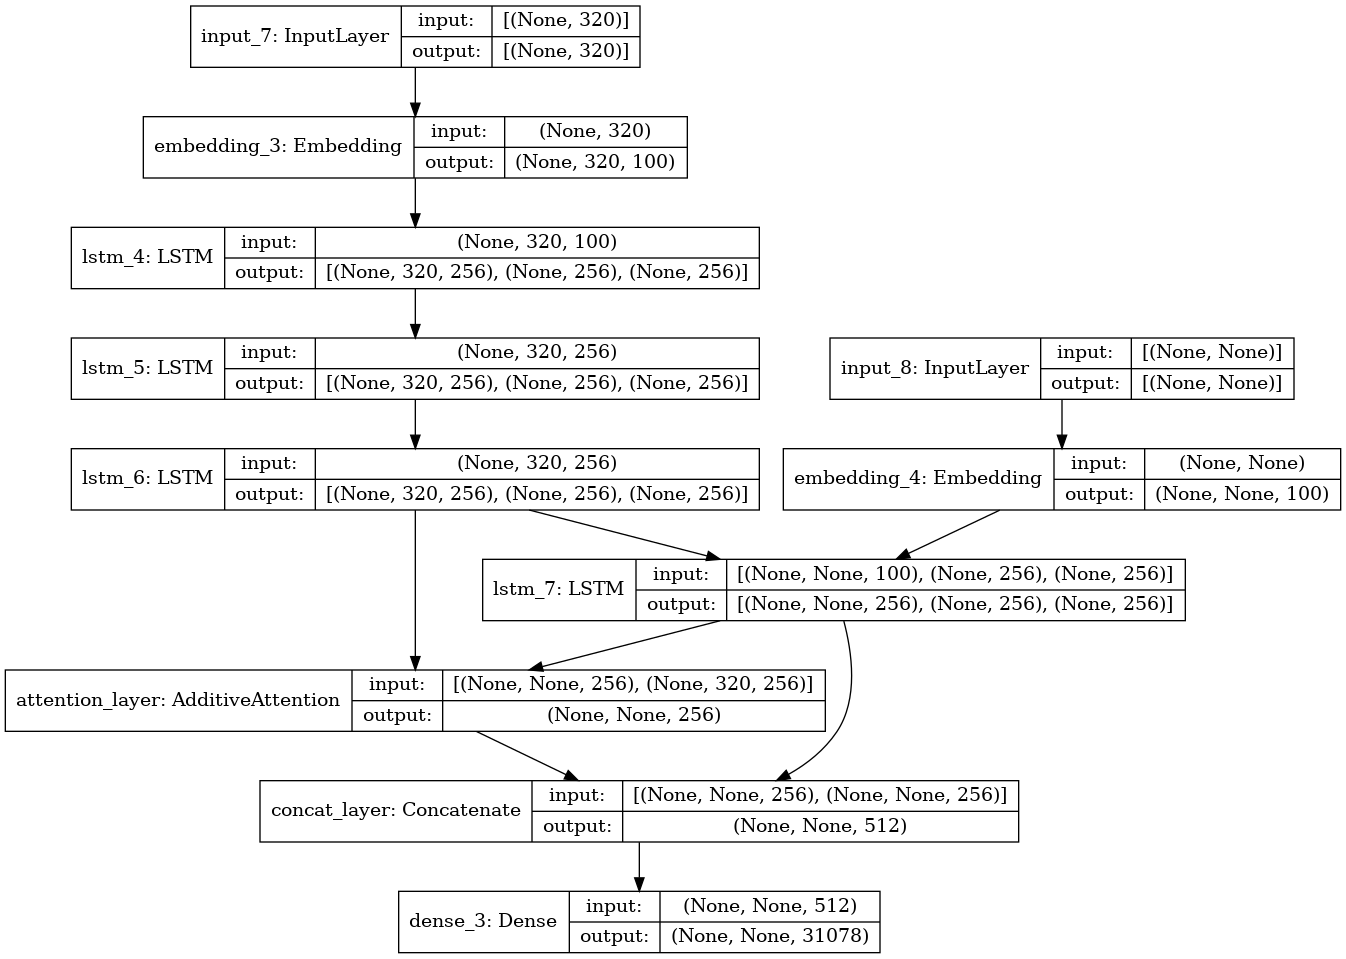

In [106]:
keras.utils.plot_model(model,"new_summary_model.png", show_shapes=True) 

# 학습하기

In [108]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=128, callbacks=[es], epochs=50)

Epoch 1/50
586/586 [==============================] - 359s 592ms/step - loss: 0.9879 - val_loss: 0.8970
Epoch 2/50
586/586 [==============================] - 342s 584ms/step - loss: 0.8714 - val_loss: 0.8286
Epoch 3/50
586/586 [==============================] - 342s 584ms/step - loss: 0.8151 - val_loss: 0.7901
Epoch 4/50
586/586 [==============================] - 342s 584ms/step - loss: 0.7753 - val_loss: 0.7636
Epoch 5/50
586/586 [==============================] - 342s 584ms/step - loss: 0.7448 - val_loss: 0.7443
Epoch 6/50
586/586 [==============================] - 342s 584ms/step - loss: 0.7202 - val_loss: 0.7289
Epoch 7/50
586/586 [==============================] - 342s 584ms/step - loss: 0.6980 - val_loss: 0.7173
Epoch 8/50
586/586 [==============================] - 342s 584ms/step - loss: 0.6813 - val_loss: 0.7093
Epoch 9/50
586/586 [==============================] - 342s 584ms/step - loss: 0.6678 - val_loss: 0.7020
Epoch 10/50
586/586 [==============================] - 342s 584m

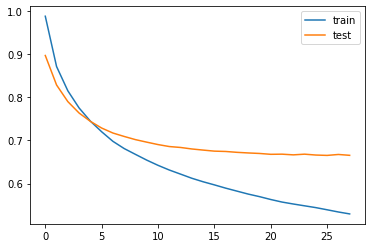

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 평가해보기

In [110]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [111]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [112]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [115]:
for i in [7,77,777,7777]:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre thursday told supreme court rohingya muslims cannot allowed stay india refugees threat national security affidavit centre said rohingya muslims could used domestic foreign terror groups create trouble country national interest warrants deportation added 
실제 요약 : rohingya muslims threat to national security govt to sc 
예측 요약 :  no longer possible for any country to india in country


원문 : partner professional services firm young us alleged firm ignored complaints another partner groped assaulted 2015 jessica claimed told trust firm reported incident human resources filed federal sexual harassment complaint firm 
실제 요약 : young accused of failing to act on groping complaint 
예측 요약 :  indian origin man accuses 2022 of stealing


원문 : goalkeeper accused france anti football team team belgium lost france 2018 fifa world cup semi final france heads corner nothing defend i would preferred lost quarters brazil added prefer lose belgium win france forward eden hazard said 
실제 요약 : fr

# 생성요약 vs 사전임베딩 생성요약 비교

|실제요약|생성요약|번역|사전임베딩생성요약|번역|
|--------|--------|----|------------------|----|
|rohingya muslims threat to national security govt to sc |no one can be allowed to stop the country of india govt|아무도 인도 정부의 나라를 막을 수 없습니다|no longer possible for any country to india in country|더 이상 어떤 나라에서도 인도할 수 없습니다|
|young accused of failing to act on groping complaint |not to be in the world case against|에게 불리한 세계적인 경우가 아닌|indian origin man accuses 2022 of stealing|인디언 출신 남성은 2022년 절도 혐의를 제기합니다|
|france an anti football team belgium keeper after wc exit|not be made to be part of world cup on return to|복귀 시에 월드컵에 참가할 수 없게 되었습니다|accept refusing to curb theft of thrones says affairs|왕위의 절도를 억제하는 것을 거부하는 것을 받아들이라고 사정들이 말합니다|
|proved married actress can score hit vidya |not to be part of being called by the end of the year|연말까지 소집되지 않는 것|am not part of my trafficking racket|내 밀매 조직의 일부가 아닙니다|

- 솔직히 사전임베딩을 사용한 모델을 사용하면 의미있는(관련된) 단어들이 많이 나올줄 알았음
- 하지만 생성요약이라 그런지 꼭 그렇지는 않았음
- 생성요약 자체가 정말 어려운 것이라는것을 깨달았음
- 영어에서도 이런 성능을 보이는데 한국어는 더 어려울것 같음..
- 하지만 모델을 발전시키기 위해 사전 임베딩된 것을 불러와서 학습을 시켜볼 수 있었다는 것에 의의를 둠
- 결과가 좋아졌다면 더 좋았을테지만 많이 아쉬움
- 하지만 모델의 훈련 자체는 잘 된것으로 생각됨
- 기본 생성 모델
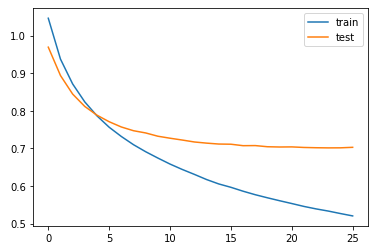
- 사전 임베딩 생성 모델
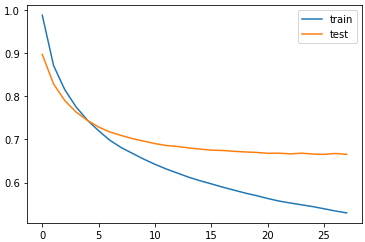

# 전체 회고
- NLP 자체는 너무 재밌는거 같음
- 모델은 전체적으로 loss값이 떨어지고 학습이 잘 되는것처럼 느껴졌지만, 막상 테스트해보면 의미있는 단어들로 요약문이 생성되지 않았음
- elploration에서 배운것들을 활용해보고자 노력했지만, 성능이 좋지는 않아서 아쉬웠음
- 또한, 한가지 알아낸 사실은 케라스 tokenizer로 num_words를 주고 limit를 걸고 사전을 만들어도, 그것이 제대로 수행되지 않는다는 것을 알았음
- 분명히 사전의 희귀단어 수와 비율을 확인하고 다시 만들었지만, tokenizer.word_index의 길이를 찍어보면 기존의 단어 수가 찍히는 것을 알았음
- 만약 이런 오류들이 해결이 됐다면 성능이 높아졌을까? 라는 생각을 해봤지만, 문자 생성이기에 장담을 할 수 없을것 같음
- 아니면 이것이 뉴스 데이터이기 때문에 차라리 구글 뉴스로 학습된 Word2Vec을 썼다면 어땠을까라는 생각도 해봄
- 이것은 곧 방학이니 개인적으로 시도해보고 싶고, 한국어로도 한번 도전해보고 싶다는 생각이 듬

# 참고 자료
- https://wikidocs.net/22893
- https://wikidocs.net/33793
- https://wikidocs.net/86083